In [471]:
import numpy as np
import scipy.io as sio
from glob import glob
from tqdm import tqdm
from scipy.signal import convolve2d
from scipy.interpolate import RectBivariateSpline
from astropy.modeling.blackbody import blackbody_lambda, blackbody_nu
from astropy.modeling import models, fitting
import astropy.units as u
import pickle
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.optimize import minimize
import sys
sys.path.append('../python/')
import chroma
%matplotlib inline
psfdir='../psf_models/psf_data_8_18_08/PSF_Mono/'

In [150]:
psf_model=pickle.load(open('psf_model.p','rb'))

In [506]:

def sumpsf(X,Y,psf_model,lam,temperature,xcent=0,ycent=0,x=None,y=None,psf_xshifts=None,psf_yshifts=None):
    
    flux_lam = blackbody_lambda(np.asarray(lam,dtype=float)*u.nanometer, temperature)
    psf2d=np.zeros((np.shape(psf_model)[1],np.shape(psf_model)[2]))
    for l,w in enumerate(flux_lam):
        model=RectBivariateSpline(X[0],Y[:,0],psf_model[l,:,:])
        psf2d+=w.value*model(X[0],Y[:,0])
    psf2d/=chroma.trapezoidal_area(np.transpose([X.ravel(),Y.ravel(),psf2d.ravel()]))
    idx=np.unravel_index(np.nanargmax(psf2d),np.shape(psf2d))
    model=RectBivariateSpline(X[0]-X[0][idx[0]]+ycent,Y[:,0]-Y[:,0][idx[1]]+xcent,psf2d)

    if ((x is None)==True)&((y is None)==True):
        return model(X[0],Y[:,0])
    else:
        return model(x,y)
    
def findcentroid(image,x=None,y=None):
    image[np.isfinite(image)==False]=0.
    s=np.shape(image)
    if (x is None)==True:
        x,_=np.meshgrid(np.arange(s[1]),np.arange(s[0]))
    if (y is None)==True:
        _,y=np.meshgrid(np.arange(s[1]),np.arange(s[0]))
    if ((x is None)==True)&((y is None)==True):
        x,y=np.meshgrid(np.arange(s[1]),np.arange(s[0]))
        

    fit=fitting.LevMarLSQFitter()
    g_init=models.Gaussian2D(x_mean=np.mean(x),y_mean=np.mean(y),amplitude=np.nanmax(image),x_stddev=0.5,y_stddev=0.5)    
    g=fit(g_init,x,y,image)
    return g.x_mean.value,g.y_mean.value

def plotcolorscale(resids,X=None,Y=None,n=5,vmin=-2,vmax=2):
    s=np.shape(resids)
    if ((X is None)==True) and ((Y is None)==True):
        X,Y=np.meshgrid(np.arange(s[1]),np.arange(s[2]))
    labels=['Redder']
    [labels.append(l) for l in ['']*int(n-2)]
    labels.append('Bluer')

    fig,ax=plt.subplots(1,n,figsize=(n*3,3))
    for j,i in enumerate(np.linspace(0,nt-1,n)):
        f=resids[int(i)]

        im=ax[j].imshow(100.*f,vmin=vmin,vmax=vmax)
        ax[j].set_title(labels[j])
    plt.suptitle('Polychromatic Model Residuals')
    cbar_ax = fig.add_axes([0.12, 0.1, 0.8, 0.03])
    cbar=fig.colorbar(im, cax=cbar_ax,orientation='horizontal')
    cbar.set_label('% Change')
    plt.savefig('abberation_demo.png',dpi=150,bbox_inches='tight')
    
    
def shape(data,plot=False,thresh=None,times=None):
    s=np.shape(data)
    shape_model=np.zeros((s[0],s[1],s[2]))
    tot=np.nansum(np.nansum(data,axis=1),axis=1)
    if plot==True:
        fig,ax=plt.subplots(s[1],s[2],figsize=(s[2]*3,s[1]*3),sharex=True)
    for i in xrange(s[1]):
        for j in xrange(s[2]):
            x,y=np.arange(len(data)),data[:,i,j]/tot
            if ((thresh is None)==True)&((times is None)==False):
                good=chroma.qualify(time,data,times)
            if ((thresh is None)==False)&((times is None)==True):
                good=np.where((np.nansum(np.nansum(data,axis=1),axis=1)!=0)&(np.nansum(np.nansum(data,axis=1),axis=1)>thresh))
            if len(good)==0:
                    continue

            flat=np.polyval(np.polyfit(x[good],y[good],3),x)
            shape_model[:,i,j]=flat
            if plot==True:
                ax[i,j].scatter(x,y,s=1)
                ax[i,j].scatter(x[good],y[good],s=1)
                ax[i,j].plot(x,flat,c='C2')
    return shape_model


In [507]:
#BANDPASS
X,Y=np.meshgrid(np.linspace(-5,5,50),np.linspace(-5,5,50))
fnames=glob('{}Module_{}/{}/*.mat'.format(psfdir,2,2+1*0.1))
lam=np.asarray([(f.split('_')[-1])[0:-4] for f in fnames],dtype='float')

temperature=9300*u.K
dt=3000
nt=200
ts=np.linspace(-dt,dt,nt)+temperature.value

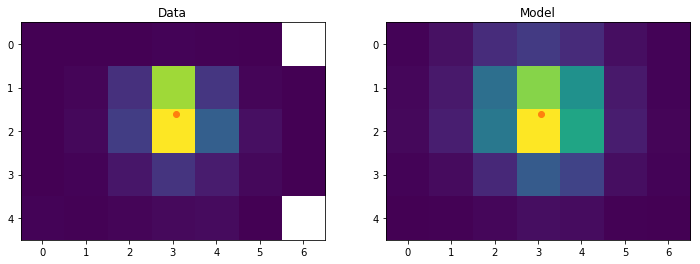

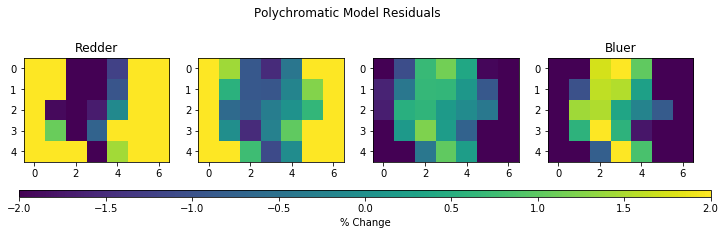

In [512]:
infile='../data/EB7.fits'
h=fits.open(infile)
data=h[1].data['FLUX']
s=np.shape(data)
output=h[0].header['OUTPUT']
module=h[0].header['MODULE']

xcent,ycent=findcentroid(np.copy(data[0]))

psf2d=sumpsf(X,Y,psf_model[module-1,output-1,:,:,:],lam,temperature,x=np.arange(s[1]),y=np.arange(s[2]),xcent=xcent,ycent=ycent)

fig,ax=plt.subplots(1,2,figsize=(12,4))
ax[0].imshow(data[0])
ax[0].scatter(xcent,ycent,c='C1')
ax[0].set_title('Data')


ax[1].imshow(psf2d)
ax[1].scatter(xcent,ycent,c='C1')
ax[1].set_title('Model')

resids=np.zeros((nt,np.shape(psf2d)[0],np.shape(psf2d)[1]))
for i,temp in enumerate(np.linspace(-dt,dt,nt)*u.K):
    resids[i,:,:]=(sumpsf(X,Y,psf_model[module-1,output-1,:,:,:],lam,temperature+temp,x=np.arange(s[1]),y=np.arange(s[2]),xcent=xcent,ycent=ycent)-psf2d)/psf2d

plotcolorscale(resids,n=4,vmin=-2,vmax=2)



In [513]:
shape_model=shape(data,times=chroma.fluxplot(infile,plot=False))
flux=[]
for dat,mod in zip(data,shape_model):
    def psf(scale):
        return 1./float(len(dat.ravel()))*np.nansum((dat-scale*mod)**2/dat)
    initial_guess=np.nanmean(dat)/np.nanmean(mod)
    f=minimize(psf,initial_guess)
    flux.append(f.x[0])
flux_model=np.asarray([f*m for f,m in zip(flux,shape_model)])

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: Mean of empty slice


In [518]:
minchis=[]
for n in np.arange(70,790):
    val=(data[n]-flux_model[n])/shape_model[n]
    e1=(data[n]**0.5/data[n])
    weights=val*e1
    chi=np.zeros(len(resids))
    for i,mod in enumerate(resids):
        chi[i]=1./(float(len(mod.ravel())))*np.nansum((val-mod)**2/weights**2)

    minchis.append(np.argmin(chi))

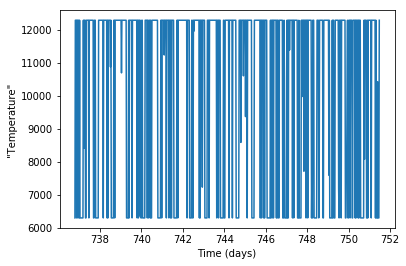

In [521]:
plt.plot(time[np.arange(70,790)],ts[minchis])
plt.ylabel('"Temperature"')
plt.xlabel('Time (days)')

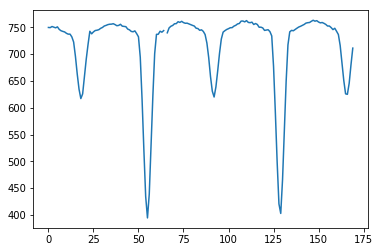

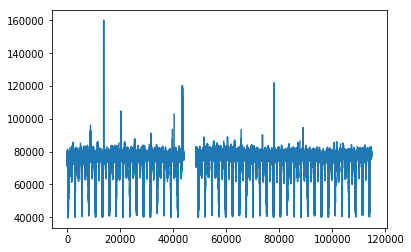

In [527]:
plt.plot((data.ravel()/shape_model.ravel()))

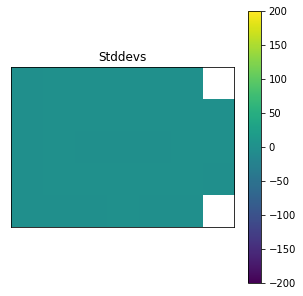

In [505]:
chroma.animateim((data-flux_model)/shape_model,vmin=-200,vmax=200,colorbar=True,title='Stddevs',outfile='EBtest.mp4')

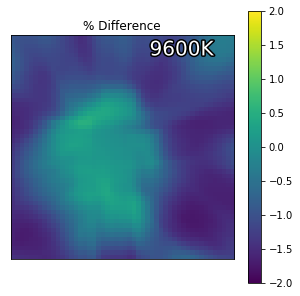

In [65]:
reload(chroma)
chroma.animateim(100.*resids/psf2d,labels=ts,outfile='../images/test.mp4',vmin=-2,vmax=2,colorbar=True,title='% Difference')

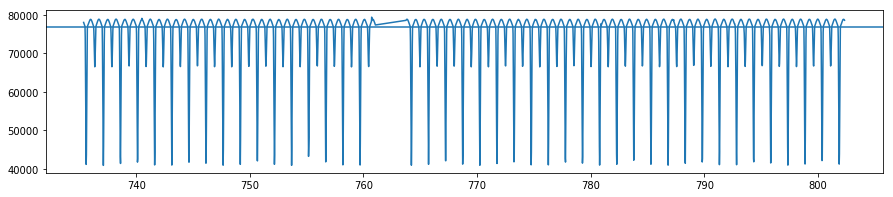

In [43]:
plt.figure(figsize=(15,3))
y=np.nansum(np.nansum(data,axis=1),axis=1)
plt.plot(time[y!=0],y[y!=0])
plt.axhline(77000)

../python/chroma.py:68: RuntimeWarning: invalid value encountered in greater_equal
  bs=set(np.where((x>=low)&(x<=high))[0])
../python/chroma.py:68: RuntimeWarning: invalid value encountered in less_equal
  bs=set(np.where((x>=low)&(x<=high))[0])


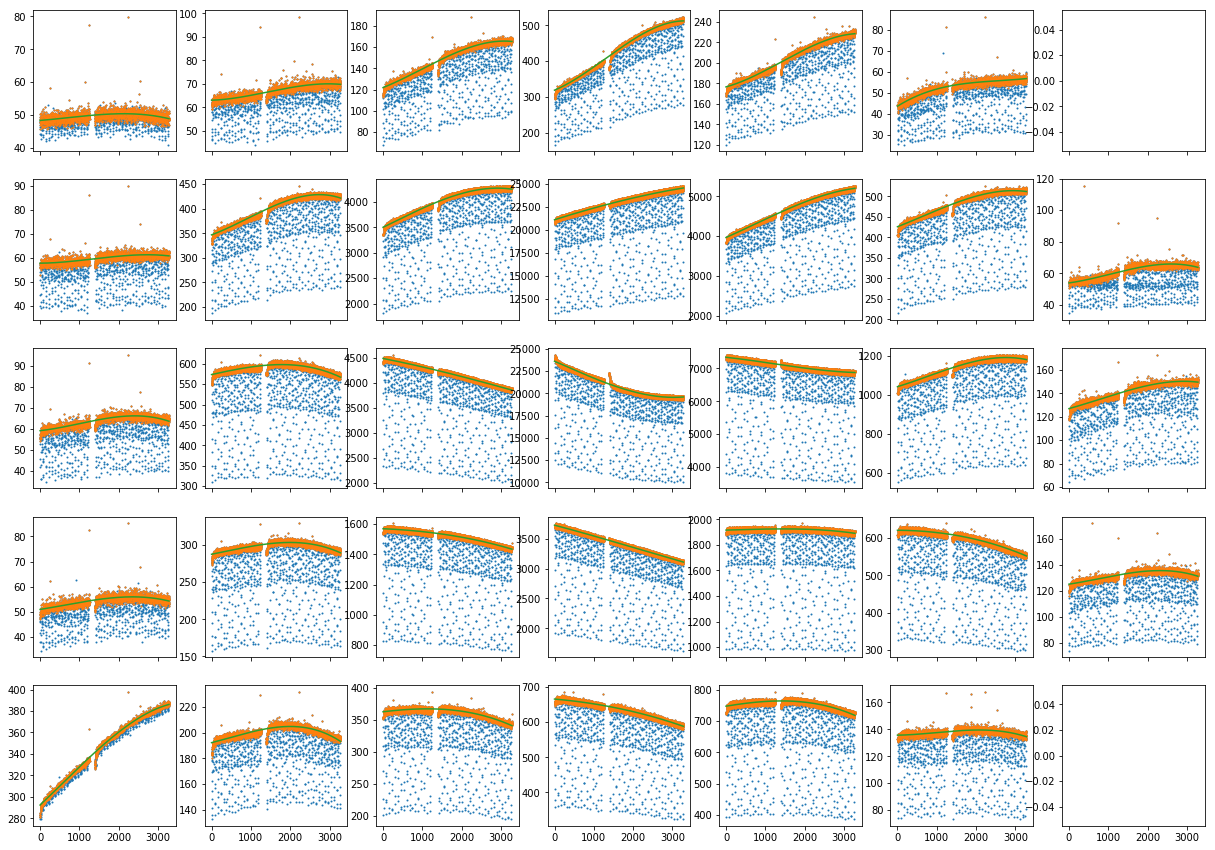

In [44]:
s=np.shape(data)
shape_model=np.zeros((s[0],s[1],s[2]))
fig,ax=plt.subplots(s[1],s[2],figsize=(s[2]*3,s[1]*3),sharex=True)
for i in xrange(s[1]):
    for j in xrange(s[2]):
        x,y=np.arange(len(data)),data[:,i,j]
        good=chroma.qualify(time,data,times)
        good=np.where((np.nansum(np.nansum(data,axis=1),axis=1)!=0)&(np.nansum(np.nansum(data,axis=1),axis=1)>77000))
        if len(good)==0:
                continue

        flat=np.polyval(np.polyfit(x[good],y[good],3),x)
        shape_model[:,i,j]=flat
        ax[i,j].scatter(x,y,s=1)
        ax[i,j].scatter(x[good],y[good],s=1)
        ax[i,j].plot(x,flat,c='C2')


In [370]:
from scipy.optimize import minimize

In [371]:
flux=[]
for dat,mod in zip(data,shape_model):
    def psf(scale):
        return 1./float(len(dat.ravel()))*np.nansum((dat-scale*mod)**2/dat)
    initial_guess=np.nanmean(dat)/np.nanmean(mod)
    f=minimize(psf,initial_guess)
    flux.append(f.x[0])
fluxmodels=np.asarray([f*m for f,m in zip(flux,shape_model)])

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: Mean of empty slice


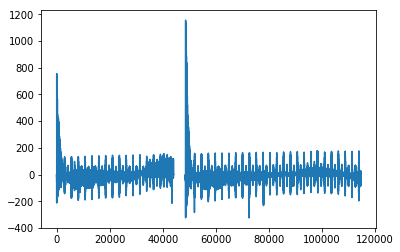

In [372]:
plt.plot(data.ravel()-fluxmodels.ravel())

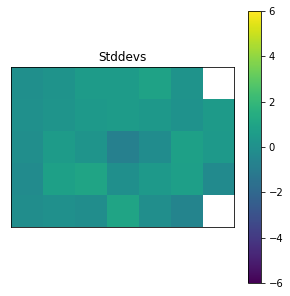

In [373]:
reload(chroma)
stds=(np.nanstd((data-fluxmodels)/data,axis=0))
vals=(data-fluxmodels)/data


chroma.animateim(vals/stds,vmin=-6,vmax=6,colorbar=True,title='Stddevs',outfile='EB6.mp4')

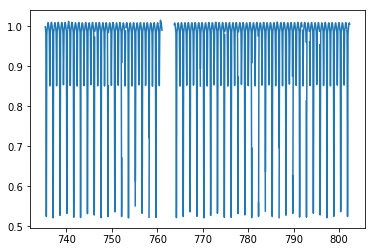

In [374]:
plt.plot(time,flux)